# I succumb to the notebook supremacy (and may the devil smite hyperspy)

In [29]:
from pathlib import Path

import numpy as np
import compress_pickle as cp
import hyperspy.io as hs_load
import hyperspy.utils.plot as hs_plot
import hyperspy._signals.signal2d as hs_signals
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import orix
import orix.crystal_map
import orix.io
import orix.quaternion
import orix.sampling
import pyxem as pxm
from diffpy.structure import Atom, Lattice, Structure, loadStructure
from diffsims.generators.simulation_generator import SimulationGenerator
from diffsims.simulations import Simulation2D

%matplotlib widget

In [2]:
# NB: Wrong atom positions
# a = 5.430986  # lattice parameter in Å
# atoms = (
#     Atom("Si", (0, 0, 0)),
#     Atom("Si", (0.25, 0, 0.25)),
#     Atom("Si", (0, 0.25, 0.25)),
#     Atom("Si", (0.25, 0.25, 0)),
# )
# lattice = Lattice(a, a, a, 90, 90, 90)
# struct = Structure(atoms, lattice)

# struct = loadStructure("mp-149_Si.cif")
# phase = orix.crystal_map.Phase(name="Si", space_group=227, structure=struct)
phase = orix.crystal_map.Phase.from_cif("mp-149_Si.cif")
phase.space_group = 227

grid = orix.sampling.get_sample_reduced_fundamental(
    resolution=0.5,
    point_group=phase.point_group,
)
simgen = SimulationGenerator(precession_angle=0.0, minimum_intensity=1e-5)

try:
    raise FileNotFoundError
    with open("simulations.pkl", "rb") as sim_f:
        simulations: Simulation2D = cp.load(sim_f, compression="gzip")
except FileNotFoundError:
    print("Running simulations")
    simulations = simgen.calculate_diffraction2d(
        phase=phase,  # Which phase(s) to simulate for
        rotation=grid,  # Which orientations to simulate for.
        reciprocal_radius=2.5,  # Max radius to consider, in reciprocal Ångström.
        with_direct_beam=False,  # Whether to include the direct beam in simulations.
        max_excitation_error=0.05,  # Maximal excitation error s, in reciprocal Ångström, used for rel-rod length.
    )
    with open("simulations.pkl", "wb") as sim_f:
        cp.dump(simulations, sim_f, compression="gzip")

Running simulations


(<Axes: xlabel='$\\AA^{-1}$', ylabel='$\\AA^{-1}$'>,
 <matplotlib.collections.PathCollection at 0x746a3f0205d0>)

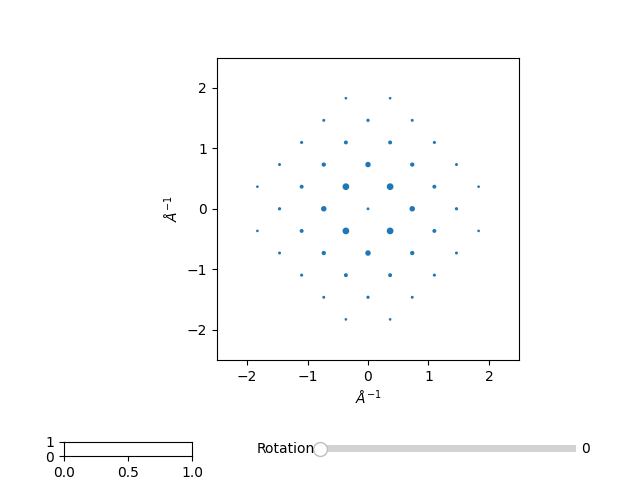

In [3]:
simulations.plot(interactive=True)

In [18]:
dataset = "Si_4"
data_folder = Path(f"../si_data/{dataset}/tiff")
# TODO: use the cred parser instead
pixelsize = 0.0036496  # (Å^-1) / px # from data collection
pixelsize = 0.00958 # From emil manual calibration
pixelsize = 0.00947 # From tina manual calibration
images = hs_load.load(dataset + ".hspy", lazy=True)

img_src = images.inav[::4]

img_src: pxm.signals.ElectronDiffraction2D = img_src
img_src.set_diffraction_calibration(pixelsize)
epsilon = 1e-10
# img_src.data = np.log(img_src.data + epsilon) - np.log(epsilon)
# img: pxm.signals.ElectronDiffraction2D = img.subtract_diffraction_background(
#     "difference of gaussians", min_sigma=6, max_sigma=20, lazy_result=False
# )


In [19]:
images.plot(norm="log")

[########################################] | 100% Completed | 1.94 sms


In [33]:
# Preprocessing
# disky: pxm.signals.ElectronDiffraction2D = img_src.template_match_disk(disk_r=8, subtract_min=False)
# disky.plot()
peaks: hs_signals.BaseSignal = img_src.get_diffraction_vectors(
    method="laplacian_of_gaussian",
    min_sigma=2.0,
    max_sigma=10.0,
    num_sigma=20,
    threshold=0.0005,
    overlap=1.0,
    log_scale=False,
    exclude_border=1,
)
peaks.compute()

print(type(peaks))

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


[########################################] | 100% Completed | 7.52 sms
<class 'pyxem.signals.diffraction_vectors.DiffractionVectors'>


In [ ]:
# peaks = disky.<get_diffraction_vectors(min_distance=8, threshold_abs=0.33)
# markers = peaks.to_markers(sizes=5, color="limegreen", alpha=0.4)
peaks_mask = peaks.to_mask(disk_r=8)

img_src.plot(norm="log")
# img_src.add_marker(markers)
img_src.data = np.log(img_src.data + epsilon) - np.log(epsilon)


img: pxm.signals.ElectronDiffraction2D = img_src * (peaks_mask) # Mask against found peaks
# img = img_src # no preprocessing

img.plot()

TypeError: BaseSignal.as_signal2D() missing 1 required positional argument: 'image_axes'

In [8]:
pol: pxm.signals.PolarDiffraction2D = img.get_azimuthal_integral2d(npt=112)
res: pxm.signals.OrientationMap = pol.get_orientation(
    simulations, n_best=5 or grid.size, frac_keep=1.0
)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


In [43]:
## Alternaltive preprocessing by removing dog background
# from pyxem.utils.expt_utils import investigate_dog_background_removal_interactive
# img_test_area = img.inav[0]

# gauss_stddev_maxs = np.arange(2, 12, 1) # min, max, step
# gauss_stddev_mins = np.arange(1, 4, 1) # min, max, step

# investigate_dog_background_removal_interactive(img_test_area,
#                                                gauss_stddev_maxs,
#                                                gauss_stddev_mins)

In [9]:
img.plot(cmap="viridis_r", norm="log")
marker: hs_plot.markers.Points = res.to_markers(annotate=True)
img.add_marker(marker)

# ?????? Total nonsense even though i removed noise
# Weird part is the markers are on masked pixels on most frames
# Image 75 is good for calibration

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


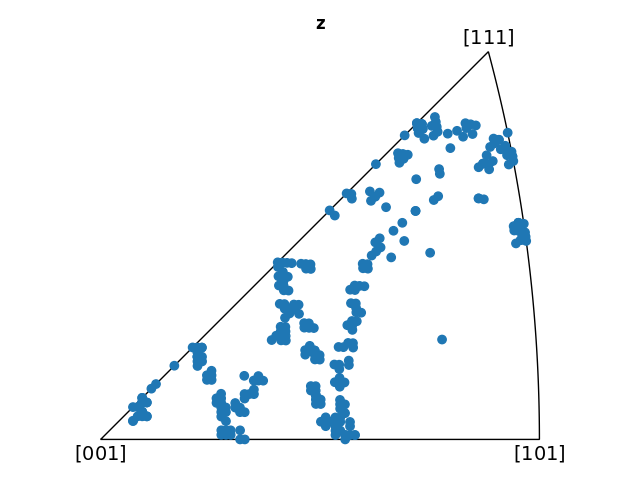

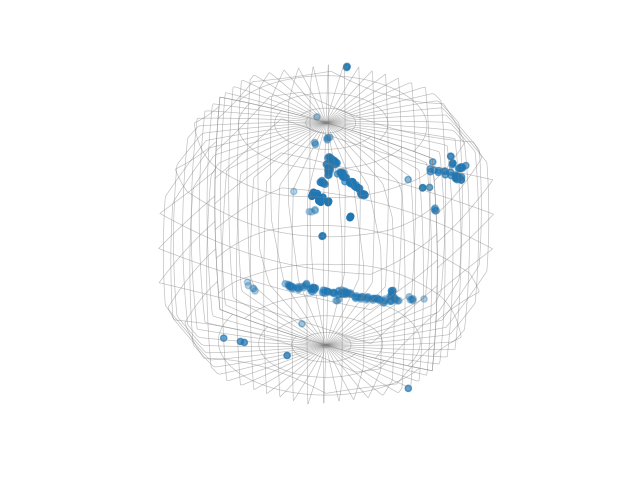

In [14]:
loris = res.to_single_phase_orientations()
loris_best = loris[:, :10]
# loris_best.symmetry = orix.symmetry.Oh
loris_best.scatter("ipf")
loris_best.scatter()


In [ ]:
print(loris_best.to_euler(degrees=True))

[[138.          31.60126792  69.78837368]
 [133.          31.60126792 110.21162632]
 [323.          31.60126792  69.78837368]
 [168.          13.70759074 108.82396334]
 [318.          31.60126792 110.21162632]
 [317.          31.60126792 110.21162632]
 [319.          31.60126792 110.21162632]
 [220.          31.60126792  69.78837368]
 [318.          31.60126792 110.21162632]
 [230.          31.60126792  69.78837368]
 [357.          13.70759074 108.82396334]
 [ 89.          17.          90.        ]
 [233.          31.60126792  69.78837368]
 [ 89.          17.          90.        ]
 [  2.          13.70759074 108.82396334]
 [155.          47.69557231  48.60812601]
 [122.          42.5         90.        ]
 [329.          42.5         90.        ]
 [155.          47.69557231  48.60812601]
 [ 39.          17.5         90.        ]
 [130.          31.60126792  69.78837368]
 [225.          31.60126792 110.21162632]
 [216.          31.60126792 110.21162632]
 [294.          47.69557231 131.39